In [1]:
import matplotlib.pyplot as plt
import os
import importlib
import pandas

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
import common_utils
importlib.reload(common_utils)
from common_utils import *
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam


In [2]:

image_paths_csv = pd.read_csv("./processed_data/image_paths_7_classes.csv")
#aug data
image_paths_csv_aug = pd.read_csv("./processed_data/image_paths_7_classes_aug.csv")

image_paths_csv = image_paths_csv[image_paths_csv['age'] >= 4]
image_paths_csv_aug = image_paths_csv_aug[image_paths_csv_aug['age'] >= 4]

# bloack for training

gendered_csv=get_gendered_images(image_paths_csv)
# get base path
image_paths_csv['base_name'] = image_paths_csv['path'].apply(get_base_name)
image_paths_csv_aug['base_name'] = image_paths_csv_aug['path'].apply(get_base_name)


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [3]:
image_paths_csv.to_csv("./processed_data/image_paths_7_classes.csv")
image_paths_csv_aug.to_csv("./processed_data/image_paths_7_classes_aug.csv")

In [29]:
gender_map = image_paths_csv.set_index('base_name')['gender'].to_dict()
image_paths_csv_aug['gender'] = image_paths_csv_aug['base_name'].map(gender_map)
merged_df = pd.concat([image_paths_csv, image_paths_csv_aug], ignore_index=True)

image_paths_csv_aug=merged_df


In [37]:
# split images in train/val/test so they don't overlap
paths_train_df, paths_val_df, paths_test_df = split_data(image_paths_csv)
paths_train_df_aug, _,_ = split_data(image_paths_csv_aug)

# one gendered csvs
paths_train_df_male = paths_train_df[paths_train_df["gender"]=="male"]
paths_val_df_male = paths_val_df[paths_val_df["gender"]=="male"]

paths_train_df_aug_male = paths_train_df_aug[paths_train_df_aug["gender"]=="male"]

# matchy amounts
paths_train_df_matched = paths_train_df.sample(n=len(paths_train_df_male), random_state=69)
paths_train_df_aug_matched = paths_train_df_aug.sample(n=len(paths_train_df_aug_male), random_state=69)

paths_val_df_matched = paths_val_df.sample(n=len(paths_val_df_male), random_state=69)


image_paths_csv_male = image_paths_csv[image_paths_csv["gender"]=="male"]
image_paths_csv_aug_male = image_paths_csv_aug[image_paths_csv_aug["gender"]=="male"]



print(len(image_paths_csv_male))
print(len(image_paths_csv_aug_male))

4145
37305


Using the original model architecture from part 1, and the original data splits, train a model
where one gender or another has been omitted from the training / validation data, but has been
left in the test data. Compare such a model to another model trained with roughly the same
number of training instances. This approach only has to be tried for the age classification task
and build this around your best performing architecture / network design from part 1.
 -> data for model training with only one gender - done
 -> test data with both genders

In [35]:

print(len(image_paths_csv))
print(len(image_paths_csv_aug))

7720
69480


In [47]:
config_count = 0

# To try to train these again to try to get the same accuracy again.
#   {"name": "A3B_relu_k5_improved_7_classes_dense_aug_batch_norm_skip", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128],"batch_norm": True,"batch_norm_dense": True, "dropout_rate": 0.5,"aug_data":True,"use_skip": True}, 
# {"name": "B2B_deep_bn_7_classes_dense_aug_batch_norm_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,"aug_data":True,"use_skip":True},
configs=[
{"name": "B2B_deep_bn_7_classes_dense_batch_norm_skip_bias", 
 "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], 
 "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,
 "aug_data":False,"use_skip":True,"resize":200, "one_gender":True},

{"name": "B2B_deep_bn_7_classes_dense_aug_batch_norm_skip_bias", 
 "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], 
 "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,
 "aug_data":True,"use_skip":True,"resize":200, "one_gender":True},

{"name": "B2B_deep_bn_7_classes_dense_batch_norm_skip_matched", 
 "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], 
 "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,
 "aug_data":False,"use_skip":True,"resize":200, "one_gender":False},

{"name": "B2B_deep_bn_7_classes_dense_aug_batch_norm_skip_matched", 
 "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], 
 "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,
 "aug_data":True,"use_skip":True,"resize":200, "one_gender":False},


]

default_args = {
    "batch_size": 64,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "classification",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}


ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    cfg_full = {**default_args, **cfg}
    cfg_full["loss"]='categorical_crossentropy' if cfg_full["task"] =="classification" else "mse"
    cfg_full["metrics"]=['accuracy'] if cfg_full["task"] =="classification" else ["mse","mae"]
    
    
    if cfg_full["one_gender"]:
        if cfg_full["aug_data"]:
            data=paths_train_df_aug_male
            val_data=paths_val_df_male
        else:
            data=paths_train_df_male
            val_data=paths_val_df_male
    else:
        if cfg_full["aug_data"]:
            data=paths_train_df_aug_matched
            val_data=paths_val_df_matched
        else:
            data=paths_train_df_matched
            val_data=paths_val_df_matched

    


    
    label_kind = "labels" if cfg_full["task"] =="classification" else "labels_regr"
    train_dataset = load_images_from_paths(tf.constant(list(data["path"])),
                                           tf.constant(list(data["age_bin"])), 
                                           channels=cfg_full["channels"],
                                           ratio=ratio,
                                           batch_size=cfg_full['batch_size'],
                                           class_count=cfg_full['num_classes'],
                                           task=cfg_full['task'],resize=200)
    
    val_dataset = load_images_from_paths(tf.constant(list(val_data["path"])),
                                         tf.constant(list(val_data["age_bin"])), 
                                         channels=cfg_full["channels"],
                                         ratio=ratio,
                                         batch_size=cfg_full['batch_size'],
                                         class_count=cfg_full['num_classes'],
                                         task=cfg_full['task'],resize=200)
                                         
    test_dataset = load_images_from_paths(tf.constant(list(paths_test_df["path"])),
                                          tf.constant(list(paths_test_df["age_bin"])),
                                          channels=cfg_full["channels"],
                                          ratio=ratio,
                                          batch_size=cfg_full['batch_size'],
                                          class_count=cfg_full['num_classes'],
                                          task=cfg_full['task'],resize=200)
    
    model = build_cnn_model(
            channels=cfg_full["channels"],
            dropout_rate=cfg_full["dropout_rate"],
            task=cfg_full["task"],
            num_classes=cfg_full["num_classes"],
            conv_filters=cfg_full["conv_filters"],
            kernel_size=cfg_full["kernel_size"],
            activation=cfg_full["activation"],
            dense_units=cfg_full["dense_units"],
            output_activation=cfg_full["output_activation"],
            batch_norm=cfg_full["batch_norm"],
            batch_norm_dense=cfg_full["batch_norm_dense"],
            use_skip=cfg_full["use_skip"],
    )

    
    optimizer = Adam(learning_rate=0.00001)
    model.compile(loss=cfg_full["loss"], optimizer=optimizer, metrics=cfg_full["metrics"])
    cfg_full["model"] = model
    cfg_full["train_data"]=train_dataset
    cfg_full["val_data"]=val_dataset
    cfg_full["test_data"]=test_dataset
    
    model_list.append(cfg_full)




In [41]:
model_list

[{'batch_size': 512,
  'epochs': 200,
  'channels': 3,
  'dropout_rate': 0.5,
  'task': 'classification',
  'num_classes': 7,
  'conv_filters': [32, 64, 128, 256, 512],
  'kernel_size': 3,
  'activation': 'relu',
  'dense_units': [512, 256, 128],
  'output_activation': 'softmax',
  'batch_norm': True,
  'batch_norm_dense': True,
  'normalize': True,
  'aug_data': True,
  'use_skip': True,
  'l2_reg': 0,
  'name': 'B2B_deep_bn_7_classes_dense_batch_norm_skip',
  'resize': 200,
  'one_gender': True,
  'loss': 'categorical_crossentropy',
  'metrics': ['accuracy'],
  'model': <keras.src.engine.functional.Functional at 0x7d030c0f7d90>,
  'train_data': <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
  'val_data': <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
  'test_data': <_

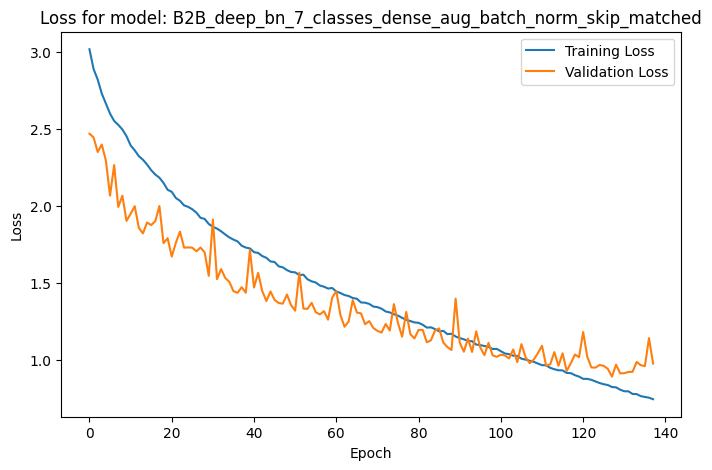

419/419 [==============================] - 16s 37ms/step - loss: 0.7441 - accuracy: 0.7007 - val_loss: 0.9756 - val_accuracy: 0.6210


In [48]:
os.makedirs(f"bias_saved_models_config_{config_count}", exist_ok=True)

for entry in model_list:
    model_name = entry["name"]
    
    # Setup model checkpoint callback
    checkpoint_path = f"bias_saved_models_config_{config_count}/{model_name}_best_model.keras"
    mse_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy' if entry["task"]=='classification' else 'val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )
    entry['best_model_path'] = checkpoint_path

    callbacks = [mse_checkpoint]

    if entry["task"]!='classification':
        mae_checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=0
        )
        callbacks.append(mae_checkpoint)

    # early_stop_loss = DelayedEarlyStopping(
    #     monitor='val_loss',
    #     patience=10,
    #     verbose=0,
    #     restore_best_weights=False,
    #     delay=120  # begin checks after 60 epochs
    # )
    
    if entry["task"]=='classification':
        early_stop_acc = DelayedEarlyStopping(
            monitor='val_accuracy',
            patience=10,
            verbose=0,
            restore_best_weights=True,
            delay=100
        )
        callbacks.append(early_stop_acc)

    # callbacks.append(early_stop_loss)
    callbacks.append(LiveLossPlot(model_name=model_name))

    # Train model
    history = entry['model'].fit(
        entry['train_data'],
        validation_data=entry['val_data'],
        epochs=entry['epochs'],
        batch_size=entry['batch_size'],
        verbose=1,
        callbacks=callbacks
    )

    # Save training history in entry
    entry['history'] = history.history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"bias_model_summary_config_{config_count}.csv", index=False)

    


    

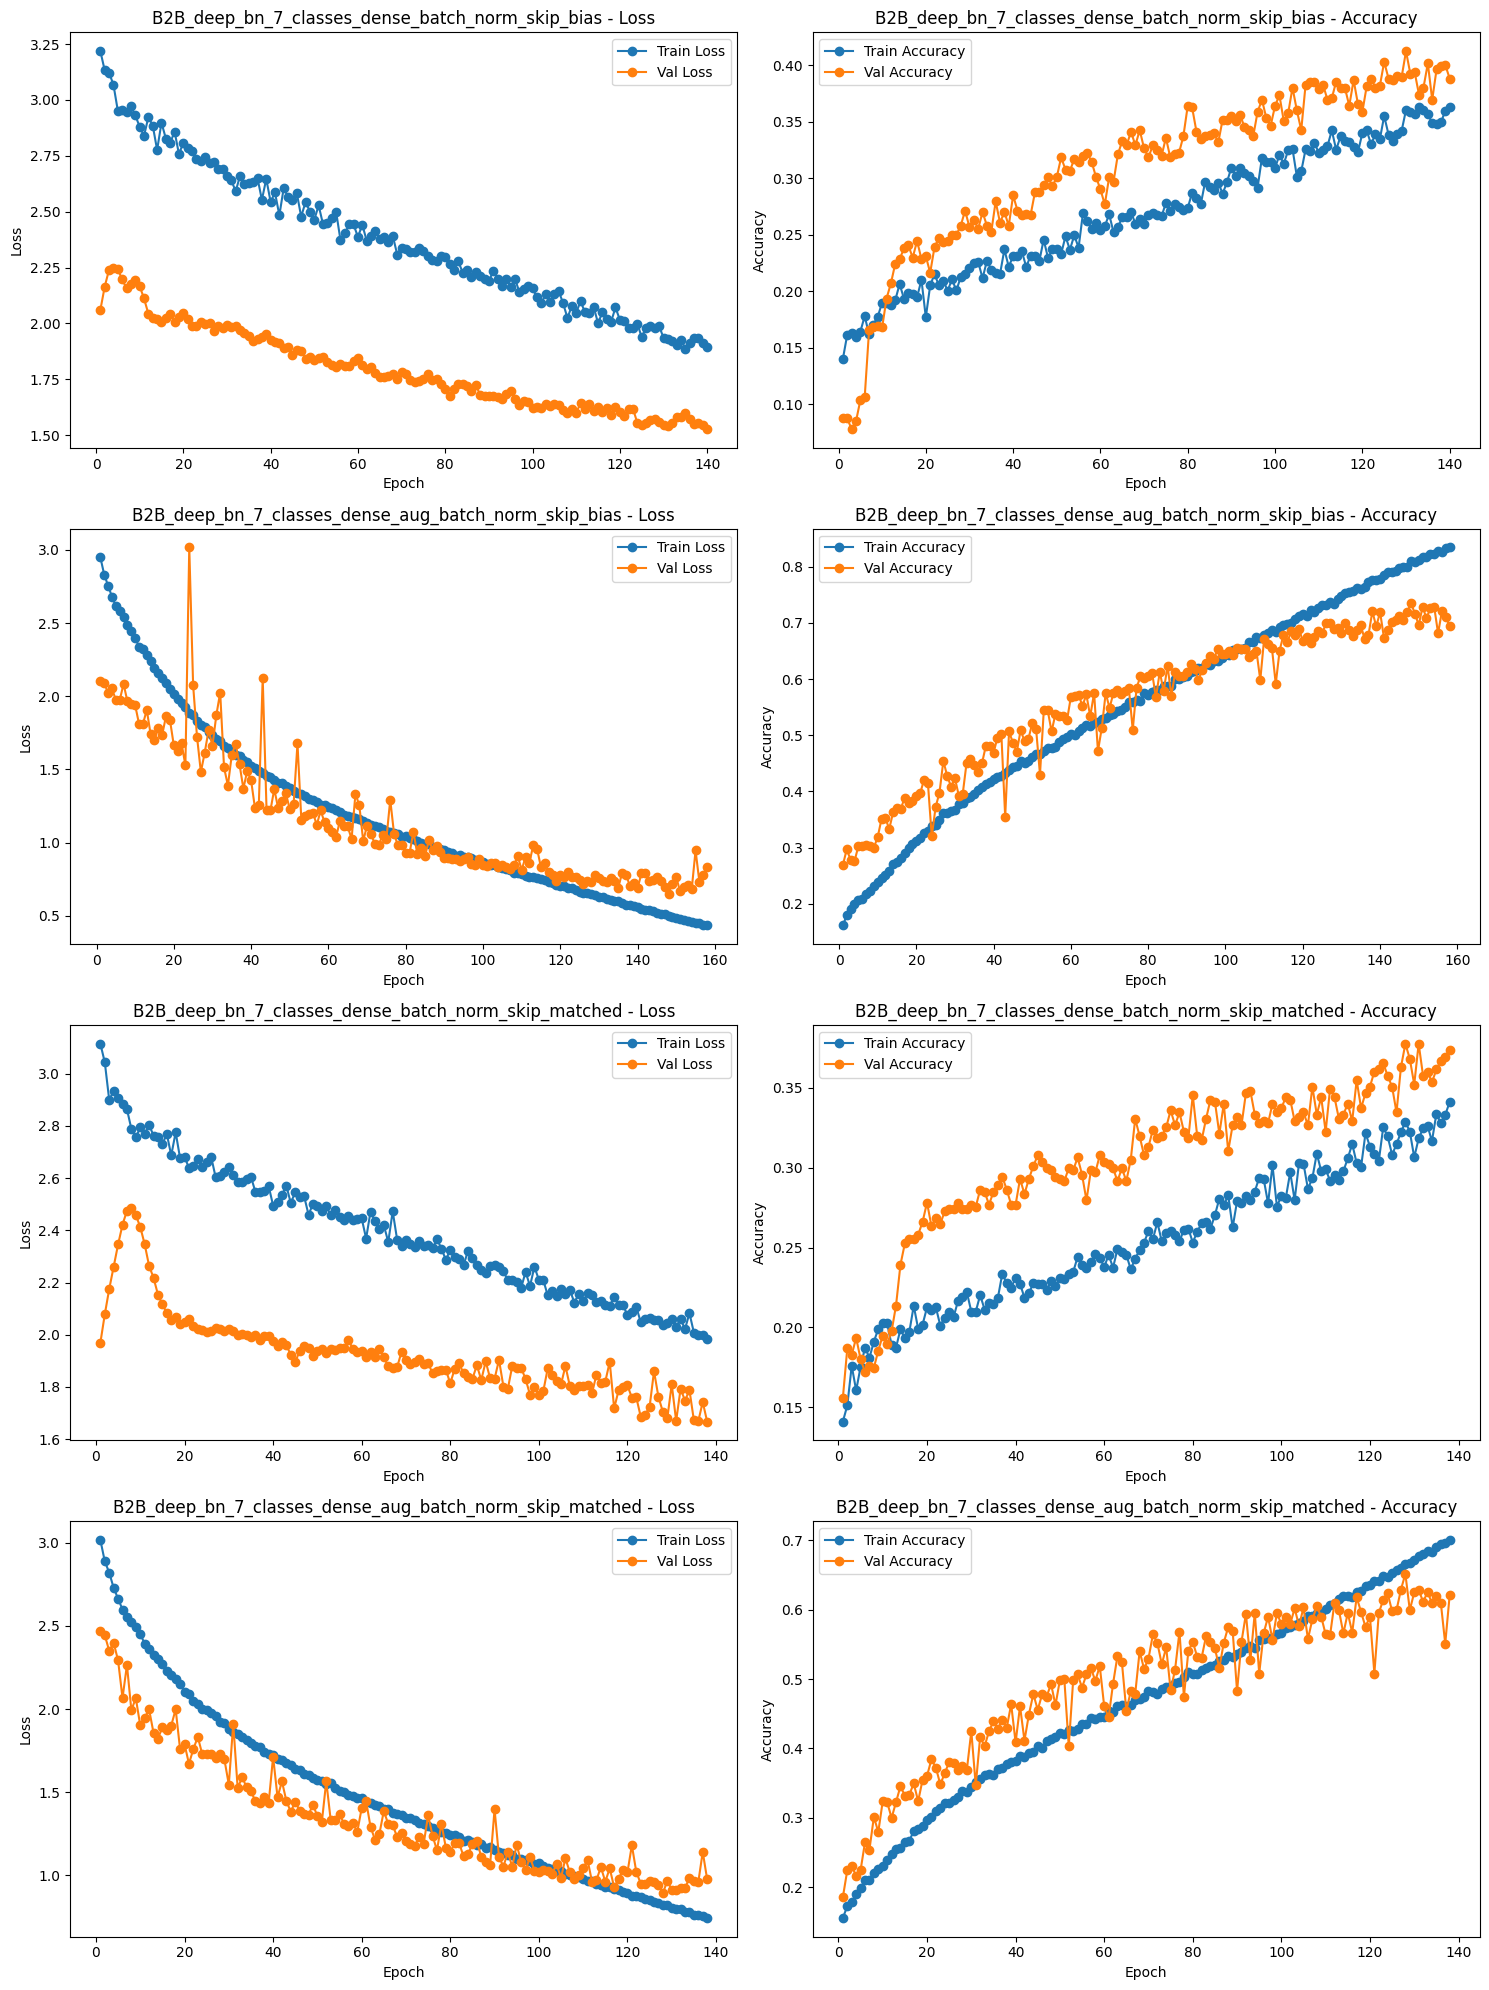

In [49]:

# Create subplots: one row per model, two columns (loss and accuracy)

fig, axes = plt.subplots(nrows=len(model_list), ncols=2, figsize=(15, 5 * len(model_list)))

# Ensure axes is always 2D
if len(model_list) == 1:
    axes = np.array([axes])

# Loop through each trained model entry
for i, entry in enumerate(model_list):
    try:
        model_name = entry["name"]
        history = entry["history"]
        epochs = list(range(1, len(history["loss"]) + 1))

        # Loss Plot
        ax_loss = axes[i, 0]
        ax_loss.plot(epochs, history["loss"], label='Train Loss', marker='o')
        ax_loss.plot(epochs, history["val_loss"], label='Val Loss', marker='o')
        ax_loss.set_title(f"{model_name} - Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()

        # Accuracy Plot
        ax_acc = axes[i, 1]
        ax_acc.plot(epochs, history["accuracy"], label='Train Accuracy', marker='o')
        ax_acc.plot(epochs, history["val_accuracy"], label='Val Accuracy', marker='o')
        ax_acc.set_title(f"{model_name} - Accuracy")
        ax_acc.set_xlabel("Epoch")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.legend()
    except Exception:
        continue

plt.tight_layout()
plt.show()

In [52]:
from tensorflow.keras.models import load_model


for i, entry in enumerate(model_list):
    
        model_name = entry["name"]
        best_model_path = f"bias_saved_models_config_{config_count}/{model_name}_best_model.keras"
        
        test_dataset = entry['test_data']
        # Load the best saved model
        
        model = load_model(best_model_path)
        

        # Evaluate on test set
        model_score = model.evaluate(test_dataset, verbose=1)
        model_labels = model.metrics_names

        print(f"🔍 {model_name} — Evaluation on Test Set:")
        for label, score in zip(model_labels, model_score):
            print(f"   {label}: {round(score, 4)}")
        print("-" * 40)

KeyboardInterrupt: 